In [ ]:
"""
ARIMA, BP neural network, and BP-ARIMA hybrid model implementation
==================================================================

Program File: python_script_fp.jpynb
Data File: production_data.csv

Model Portfolio:
-----------------

1. ARIMA Model: Capture linear pattern in time series
2. BP Neural Network: Caputure nonlinear pattern
3. Hybrid BP-ARIMA: Conbines both for linear and nonlinear trend modeling


Evaluation Framework:
---------------------

Models' accuracy metrics:

- MAE
- RMSE
- MAPE

Residual diagnostics:
Ljung-Box test

"""

"\nARIMA, BP Neural Network, and BP-ARIMA HYBRID MODEL IMPLEMENTATION\n==================================================================\n\nProgram File: python_script_fp.jpynb\nData File: production_data.csv\n\nModel Portfolio:\n-----------------\n\n1. ARIMA Model: Capture linear pattern in time series\n2. BP Neural Network: Caputure nonlinear pattern\n3. Hybrid BP-ARIMA: Conbines both for linear and nonlinear trend modeling\n\n\nEvaluation Framework:\n---------------------\n\nModels' accuracy metrics:\n\n- MAE\n- RMSE\n- MAPE\n\nResidual diagnostics:\nLjung-Box test\n\n"

In [2]:
#### 1. Data read and data  prepartion code
# Here data divided into three groups (1972-2023, 1984-2023,1984-2023)

import pandas as pd
df = pd.read_csv("production_data.csv")
df['Year'] = df['Year'].astype(int)

# Helper function to filter columns with full data in a year range
def get_full_data_columns(df, start_year, end_year):
    temp = df[df['Year'].between(start_year, end_year)]
    valid_cols = temp.dropna(axis=1).columns
    return temp[valid_cols]

# 1. Variables with data available from 1972–2023
df_1972_2023 = get_full_data_columns(df, 1972, 2023)

# 2. Variables with data available from 1984–2023
df_1984_2023 = get_full_data_columns(df, 1984, 2023)

# 4. Variables with data available from 2000–2022
df_1988_2024 = get_full_data_columns(df, 1988, 2024)


# Show summary info
print("1972–2023:", df_1972_2023.shape)
print("1984–2023:", df_1984_2023.shape)
print("1988–2024:", df_1988_2024.shape)

1972–2023: (52, 2)
1984–2023: (40, 3)
1988–2024: (37, 2)


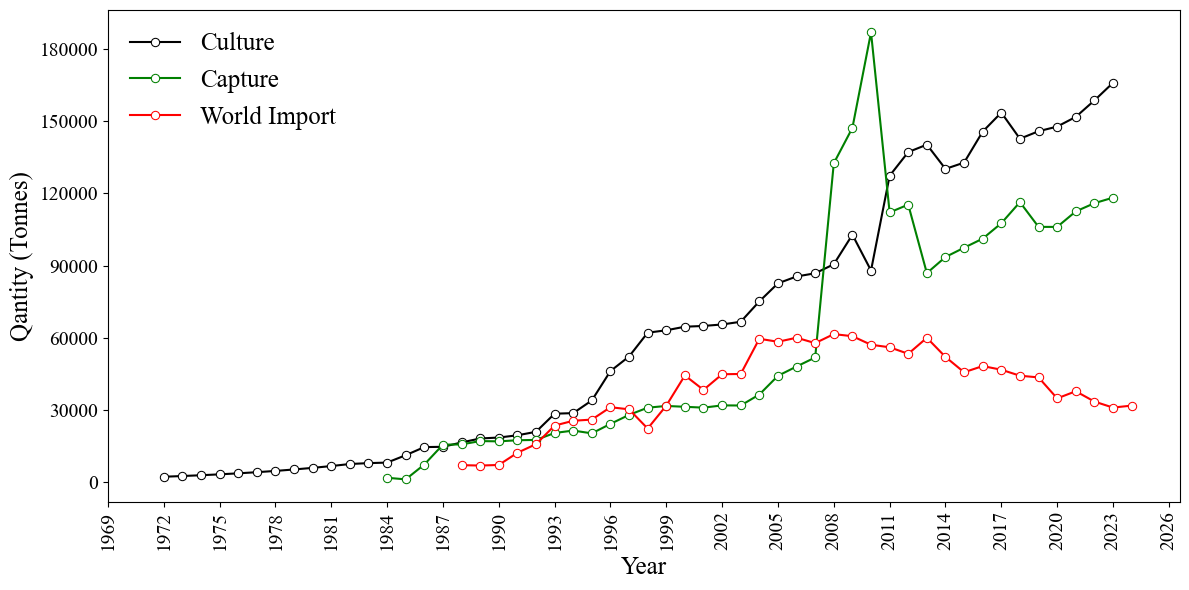

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

sns.lineplot(data=df_1972_2023, x="Year", y="Culpro(MT)",marker='o', markerfacecolor='white', markeredgecolor='black',color="black", label="Culture")
sns.lineplot(data=df_1984_2023 , x="Year", y="Cappro(MT)",marker='o', markerfacecolor='white', markeredgecolor='green',color="green", label="Capture")
sns.lineplot(data=df_1988_2024, x="Year", y="World_Import",marker="o", markerfacecolor='white', markeredgecolor='red',color="red", label="World Import")

plt.ylabel("Qantity (Tonnes)", fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.legend(
    frameon=False,  
    fontsize=18,    
)

plt.yticks(np.arange(0, 180001, 30000), fontsize=14)

plt.xticks(np.arange(1969, 2029, 3), fontsize=14, rotation=90)
plt.tight_layout()
plt.savefig("D:/Culture Capture and World_TNR.png", dpi=600, bbox_inches='tight')
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f'{name} ADF Statistic: {result[0]:.4f}')
    print(f'{name} p-value: {result[1]:.4f}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')
    print("-" * 40)

# Run tests
adf_test(df_1972_2023['Culpro(MT)'], 'Culture Production')

Culture Production ADF Statistic: 0.7978
Culture Production p-value: 0.9916
Non-stationary
----------------------------------------


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create first-order differenced data
df_diff = df_1972_2023.copy()
df_diff["Diff_Culpro(MT)"] = df_diff["Culpro(MT)"].diff()

from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f'{name} ADF Statistic: {result[0]:.4f}')
    print(f'{name} p-value: {result[1]:.4f}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')
    print("-" * 40)

# Run tests
adf_test(df_diff["Diff_Culpro(MT)"], 'first oder diff. Culture Production')


first oder diff. Culture Production ADF Statistic: -8.1199
first oder diff. Culture Production p-value: 0.0000
Stationary
----------------------------------------


In [6]:
import numpy as np
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox

# =================== Data Split (Fixed Test Size = 5) ===================
y = df_1972_2023['Culpro(MT)'].astype(float)

test_size = 5
train_size = len(y) - test_size

train_data = y.iloc[:train_size]
test_data  = y.iloc[train_size:]

print(f"Train: {len(train_data)} records, Test: {len(test_data)} records")

# =================== Auto ARIMA on TRAINING data only ===================
model = pm.auto_arima(
    train_data,
    information_criterion='bic',
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None,          # Let model determine differencing
    start_d=0, max_d=2,
    trace=True
)

print(f"\nBest model: {model}")

# =================== Predict on Test ===================
predictions = model.predict(n_periods=len(test_data))

# =================== Accuracy Metrics ===================
mae = mean_absolute_error(test_data, predictions)
rmse = np.sqrt(mean_squared_error(test_data, predictions))

# ======================================================
# Performance Metrics
# ======================================================
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape(test_data, predictions):.2f}%")

# =================== Ljung-Box Test (Residual Autocorrelation) ===================
# H0: residuals are independently distributed (no autocorrelation)
residuals = model.arima_res_.resid

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test (H0: No autocorrelation in residuals):")
print(lb_test)
print(f"p-value (lag 10): {lb_test['lb_pvalue'].values[0]:.4f}")

if lb_test['lb_pvalue'].values[0] < 0.05:
    print("-> Reject H0: Residuals are autocorrelated.")
else:
    print("-> Fail to reject H0: Residuals appear to be white noise.")

Train: 47 records, Test: 5 records
Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=959.489, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=961.942, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=962.390, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=962.660, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=965.942, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.119 seconds

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
MAE: 2578.12
RMSE: 3958.59
MAPE: 1.59%

Ljung-Box Test (H0: No autocorrelation in residuals):
     lb_stat  lb_pvalue
10  6.672412   0.755967
p-value (lag 10): 0.7560
-> Fail to reject H0: Residuals appear to be white noise.


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# Set all random seeds (UNCHANGED)
# -----------------------------
np.random.seed(68)
tf.random.set_seed(68)

# =================== Load and Prepare Data ===================
data = df_1972_2023[['Year', 'Culpro(MT)']].copy()
data.set_index('Year', inplace=True)

# Fix test size to 5 (same idea as ARIMA)
test_size = 5
train_size = len(data) - test_size
train, test = data.iloc[:train_size], data.iloc[train_size:]

ts_train = np.array(train).flatten()
ts_test  = np.array(test).flatten()

# =================== Scale (fit only on training) ===================
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(ts_train.reshape(-1, 1))

# =================== Create lag features (UNCHANGED lag=3) ===================
lag = 3
ts_scaled_train = scaler.transform(ts_train.reshape(-1, 1))

X_train, y_train = [], []
for i in range(lag, len(ts_scaled_train)):
    X_train.append(ts_scaled_train[i-lag:i, 0])
    y_train.append(ts_scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# =================== Build & Train BP model (UNCHANGED specification) ===================
initializer = tf.keras.initializers.GlorotUniform(seed=42)

bp_model = Sequential([
    Dense(16, activation='relu', input_dim=lag, kernel_initializer=initializer),
    Dense(8, activation='relu', kernel_initializer=initializer),
    Dense(1, kernel_initializer=initializer)
])

bp_model.compile(optimizer='adam', loss='mse')
bp_model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=0, shuffle=False)

# =================== Prepare TEST lag features ===================
full_series = np.concatenate([ts_train, ts_test])
full_scaled = scaler.transform(full_series.reshape(-1, 1))

start_idx = len(ts_train) - lag
X_test = []
for i in range(start_idx + lag, len(full_scaled)):
    if i >= len(ts_train):  # only test period
        X_test.append(full_scaled[i-lag:i, 0])
X_test = np.array(X_test)

# =================== Predict TEST ===================
bp_forecast_scaled = bp_model.predict(X_test, verbose=0)
bp_forecast = scaler.inverse_transform(bp_forecast_scaled).flatten()

# =================== Metrics: MAE, RMSE, MAPE (ONLY) ===================
rmse = np.sqrt(mean_squared_error(ts_test, bp_forecast))
mae = mean_absolute_error(ts_test, bp_forecast)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100

mape = mean_absolute_percentage_error(ts_test, bp_forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# =================== Ljung-Box Test (Version A: adaptive lag) ===================
train_pred_scaled = bp_model.predict(X_train, verbose=0)
train_pred = scaler.inverse_transform(train_pred_scaled).flatten()

actual_train_values = ts_train[lag:]  # aligns with X_train/y_train
train_residuals = actual_train_values - train_pred

max_lags = min(10, len(train_residuals)//2 - 1)
if max_lags > 0:
    lb_test = acorr_ljungbox(train_residuals, lags=[max_lags], return_df=True)
    print("\nLjung-Box Test (H0: No autocorrelation in residuals):")
    print(lb_test)
    print(f"p-value (lag {max_lags}): {lb_test['lb_pvalue'].values[0]:.4f}")
else:
    print("\nNot enough residuals to run Ljung-Box test safely.")

MAE: 3372.61
RMSE: 3708.46
MAPE: 2.20%

Ljung-Box Test (H0: No autocorrelation in residuals):
     lb_stat  lb_pvalue
10  7.389523    0.68823
p-value (lag 10): 0.6882


In [8]:
# Required Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import pmdarima as pm
import random
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# SET ALL RANDOM SEEDS
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load your time series data
ts_values = df_1972_2023['Culpro(MT)'].values
years = df_1972_2023['Year'].values

# =================== FIXED TEST SIZE = 5 ===================
test_size = 5
train_size = len(ts_values) - test_size

# Split using array slicing
train_data = ts_values[:train_size]
test_data  = ts_values[train_size:]

train_years = years[:train_size]
test_years  = years[train_size:]

print(f"Train: {len(train_data)} records ({train_years[0]}–{train_years[-1]})")
print(f"Test: {len(test_data)} records ({test_years[0]}–{test_years[-1]})")

# ------------------------------
# Step 1: Fit ARIMA model on TRAINING data
# ------------------------------
print("Fitting ARIMA model...")

arima_model = pm.auto_arima(train_data, 
                           information_criterion='bic',
                          seasonal=False,
                          stepwise=True,
                          suppress_warnings=True,
                          start_p=1, start_q=1,
                          max_p=5, max_q=5,
                          d=None,  
                          start_d=0, max_d=1,
                          trace=True) 
                      

# Get ARIMA predictions for both training and test
arima_train_pred = arima_model.predict_in_sample()
arima_test_pred = arima_model.predict(n_periods=len(test_data))

# Calculate residuals for training data
train_residuals = train_data - arima_train_pred

print("ARIMA model fitted successfully!")

# ------------------------------
# Step 2: Prepare residuals for BP neural network (TRAINING ONLY)
# ------------------------------
# Scale the training residuals
scaler_residuals = MinMaxScaler(feature_range=(0,1))
train_residuals_scaled = scaler_residuals.fit_transform(train_residuals.reshape(-1,1))

# Create lag features for training
X_train, y_train = [], []
lag = 3
for i in range(lag, len(train_residuals_scaled)):
    X_train.append(train_residuals_scaled[i-lag:i, 0])
    y_train.append(train_residuals_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(f"Training data - X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# ------------------------------
# Step 3: Build and Train BP neural network
# ------------------------------
# Define initializer
initializer = tf.keras.initializers.GlorotUniform(seed=6)

bp_model = Sequential([
   Dense(4, activation='relu', input_dim=lag, kernel_initializer=initializer),
   Dense(2, activation='relu', kernel_initializer=initializer),
   Dense(1, kernel_initializer=initializer)
])

# Train the model
#bp_model.compile(optimizer='adam', loss='mse')
bp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

print("Training BP neural network...")
bp_model.fit(X_train, y_train, epochs=250, batch_size=2, verbose=0, shuffle=False)
print("BP neural network training completed!")

# ------------------------------
# Step 4: OUT-OF-SAMPLE TEST EVALUATION
# ------------------------------
# Prepare test data for hybrid forecasting
test_residuals_pred_scaled = []

# Start with the last 'lag' residuals from training
current_input = train_residuals_scaled[-lag:].reshape(1, -1)

# Recursively predict residuals for test period
for i in range(len(test_data)):
    # Predict next residual
    next_residual_pred = bp_model.predict(current_input, verbose=0)
    test_residuals_pred_scaled.append(next_residual_pred[0, 0])
    
    # Update input for next prediction
    current_input = np.column_stack([current_input[:, 1:], next_residual_pred])

# Convert scaled residuals back to original scale
test_residuals_pred = scaler_residuals.inverse_transform(
    np.array(test_residuals_pred_scaled).reshape(-1, 1)
).flatten()

# Create hybrid forecast for test period
hybrid_test_forecast = arima_test_pred + test_residuals_pred

# Actual test values
actual_test_values = test_data

# Calculate OUT-OF-SAMPLE evaluation metrics
test_mae = mean_absolute_error(actual_test_values, hybrid_test_forecast)
test_rmse = np.sqrt(mean_squared_error(actual_test_values, hybrid_test_forecast))
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100

test_mape = mean_absolute_percentage_error(actual_test_values, hybrid_test_forecast)

print("=" * 60)
print("OUT-OF-SAMPLE TEST EVALUATION METRICS")
print("=" * 60)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")

Train: 47 records (1972–2018)
Test: 5 records (2019–2023)
Fitting ARIMA model...
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=965.942, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=959.489, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=961.942, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=962.390, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=962.660, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.074 seconds
ARIMA model fitted successfully!
Training data - X_train shape: (44, 3), y_train shape: (44,)
Training BP neural network...
BP neural network training completed!
OUT-OF-SAMPLE TEST EVALUATION METRICS
Test MAE: 3088.2195
Test RMSE: 3849.9264
Test MAPE: 1.95%


In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# Set all random seeds for reproducibility
# -----------------------------
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# =================== Load and Prepare Data ===================
data = df_1972_2023[['Year', 'Culpro(MT)']].copy()
data.set_index('Year', inplace=True)

# =================== FIXED TEST SIZE = 5 (Like Model 1) ===================
test_size = 5  # Fixed test size
train_size = len(data) - test_size

# Split using iloc
train = data.iloc[:train_size]
test = data.iloc[train_size:]

print(f"Train: {len(train)} records ({train.index[0]}–{train.index[-1]})")
print(f"Test: {len(test)} records ({test.index[0]}–{test.index[-1]})")

# Convert to numpy - KEEP IN ORIGINAL SCALE
ts_train = np.array(train)  # Already in original units
ts_test = np.array(test)    # Keep test data for potential evaluation

# =================== ARIMA MODEL COMPONENT ===================
arima_model = pm.auto_arima(ts_train.flatten(),
                           information_criterion='bic',
                           seasonal=False,
                           stepwise=True,
                           suppress_warnings=True,
                           start_p=1, start_q=1,
                           max_p=5, max_q=5,
                           d=None,
                           start_d=0, max_d=1,
                           trace=True)

# Get ARIMA training predictions
arima_train_predictions = arima_model.predict_in_sample()

# Calculate ARIMA residuals
arima_residuals = ts_train.flatten() - arima_train_predictions

# =================== BP NEURAL NETWORK COMPONENT ===================
# Use ARIMA residuals as target for BP network
lag = 3
scaler_residuals = MinMaxScaler(feature_range=(0, 1))
arima_residuals_scaled = scaler_residuals.fit_transform(arima_residuals.reshape(-1, 1))

# Create lag features for BP model
X_train_bp, y_train_bp = [], []
for i in range(lag, len(arima_residuals_scaled)):
    X_train_bp.append(arima_residuals_scaled[i-lag:i, 0])
    y_train_bp.append(arima_residuals_scaled[i, 0])

X_train_bp, y_train_bp = np.array(X_train_bp), np.array(y_train_bp)

# Build and train BP neural network
initializer = tf.keras.initializers.GlorotUniform(seed=6)
bp_model = Sequential([
    Dense(4, activation='relu', input_dim=lag, kernel_initializer=initializer),
    Dense(2, activation='relu', kernel_initializer=initializer),
    Dense(1, kernel_initializer=initializer)
])

bp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
bp_model.fit(X_train_bp, y_train_bp, epochs=250, batch_size=2, verbose=0, shuffle=False)

# =================== HYBRID MODEL TRAINING PREDICTIONS ===================
# Get BP predictions on training data
bp_residual_predictions_scaled = bp_model.predict(X_train_bp, verbose=0)
bp_residual_predictions = scaler_residuals.inverse_transform(bp_residual_predictions_scaled).flatten()

# Create hybrid predictions: ARIMA + BP corrected residuals
hybrid_train_predictions = arima_train_predictions[lag:] + bp_residual_predictions

# Get actual values for the corresponding period
actual_hybrid_values = ts_train[lag:].flatten()

# =================== CALCULATE HYBRID MODEL RESIDUALS ===================
hybrid_residuals = actual_hybrid_values - hybrid_train_predictions

# =================== LJUNG-BOX TEST ON HYBRID RESIDUALS ===================
max_lags = min(10, len(hybrid_residuals)//2 - 1)
if max_lags > 0:
    lb_test = acorr_ljungbox(hybrid_residuals, lags=[max_lags], return_df=True)
    
    print("="*60)
    print("HYBRID MODEL RESIDUAL DIAGNOSTICS: LJUNG-BOX TEST")
    print("="*60)
    print("Null Hypothesis: No autocorrelation in hybrid model residuals")
    print("Test Results:")
    print(f"     lb_stat  lb_pvalue")
    print(f"10  {lb_test['lb_stat'].values[0]:.6f}   {lb_test['lb_pvalue'].values[0]:.6f}")
    print(f"p-value for lag 10: {lb_test['lb_pvalue'].values[0]:.4f}")
    
    if lb_test['lb_pvalue'].values[0] < 0.05:
        print("-> SIGNIFICANT: p-value < 0.05. Reject null hypothesis.")
        print("-> There IS significant autocorrelation in the hybrid model residuals.")
        print("-> The hybrid model has not captured all patterns in the data.")
    else:
        print("-> NOT SIGNIFICANT: p-value >= 0.05. Cannot reject null hypothesis.")
        print("-> There is NO significant autocorrelation in the hybrid model residuals.")
        print("-> The hybrid model residuals appear to be white noise (EXCELLENT model fit).")
else:
    print("Not enough data points for Ljung-Box test")

Train: 47 records (1972–2018)
Test: 5 records (2019–2023)
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=965.942, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=959.489, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=961.942, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=962.390, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=962.660, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.092 seconds
HYBRID MODEL RESIDUAL DIAGNOSTICS: LJUNG-BOX TEST
Null Hypothesis: No autocorrelation in hybrid model residuals
Test Results:
     lb_stat  lb_pvalue
10  5.293788   0.870709
p-value for lag 10: 0.8707
-> NOT SIGNIFICANT: p-value >= 0.05. Cannot reject null hypothesis.
-> There is NO significant autocorrelation in the hybrid model residuals.
-> The hybrid model residuals appear to be white noise (EXCELLENT model fit).
